In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import mapping
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import shutil
from datetime import datetime
import pandas as pd
from terminus import termpicks_trace, termpicks_centerline, termpicks_interpolation
from shapely.ops import nearest_points
from shapely.affinity import translate
from shapely.geometry import Point, LineString, Polygon
from rasterio.warp import reproject, Resampling, calculate_default_transform
import rasterio

In [4]:
#TO DO 
#interpolate vertices to my og polygon so I can extend my lines to connect without having to go into qgis

In [477]:
termpicks = gpd.read_file('Terminus/TermPicks+Calfin_v2/TermPicks+CALFIN_V2.shp')
termpicks = termpicks[termpicks['GlacierID']==1]

In [478]:
dems = os.listdir('1')
masked = []
for file in dems:
    if file.endswith("dem_masked.tif"):
        masked.append(file)

In [ ]:
#APPROVE DEMS
approve = []
for file in masked:
    lidar_chm_im = rxr.open_rasterio("1/" + file,
                                 masked=True).squeeze()

    f, ax = plt.subplots(figsize=(10, 5))
    lidar_chm_im.plot.imshow()
    ax.set_axis_off()
    plt.show()
    
    approve.append(input())
textfile = open("DEM_approve/1.txt", "w")
for element in approve:
    textfile.write(element + "\n")
textfile.close()  

final = []
for file, app in zip(masked,approve):
    if app == 'y':
        final.append(file)
        scr = '1/'+file
        dst = 'Approved_DEMS/1/' + file
        shutil.copyfile(scr, dst)

In [480]:
#Get the DEM dates list

#Get the DEM dates list
dem_dates = []
for dem in final:
    f_date = dem[18:26]
    y = f_date[0:4]
    m= f_date[4:6]
    d = f_date[6:8]
    date = y + '-' + m + '-' + d
    datetime_object = datetime.strptime(date, '%Y-%m-%d')
    dem_dates.append(datetime_object)

#Get the Zhang dates list
z_term_direct= os.listdir('Terminus/Shapefiles')
z_terminus_traces =[item for item in z_term_direct if item.endswith('.shp')]
zhang_dates = []
for trace in z_terminus_traces:
    z_date = trace[4:12]
    y = z_date[0:4]
    m= z_date[4:6]
    d = z_date[6:8]
    date = y + '-' + m + '-' + d
    datetime_object = datetime.strptime(date, '%Y-%m-%d')
    zhang_dates.append(datetime_object)
    
#Get the TermPicks date list
tp_datestr = termpicks['Date'].to_list()
tp_dates = []
for date in tp_datestr:
    datetime_object = datetime.strptime(date, '%Y-%m-%d')
    tp_dates.append(datetime_object)
    
#Get new picks dates to list
n_picks = gpd.read_file('Terminus/New_traces/DEM_Traces_polar.shp')
n_picks = n_picks.to_crs("EPSG:3413")
n_datestr = n_picks['Date'].to_list()
n_dates = []
for date in n_datestr:
    datetime_object = datetime.strptime(date, '%Y-%m-%d')
    n_dates.append(datetime_object)

In [481]:
indexs = []
for date,file in zip(dem_dates,final):
    if date in zhang_dates:
        indexs.append((file,date,'zhang',zhang_dates.index(date)))
    elif date in tp_dates:
        indexs.append((file,date,'tp',tp_dates.index(date)))
    elif date in n_dates:
        indexs.append((file,date,'new',n_dates.index(date)))
    else:
        indexs.append((file,date,'none',1))
dem_df = pd.DataFrame(indexs, columns =['DEM','Date','Terminus','Index']) 
need_picks = dem_df[dem_df['Terminus'] == 'none']['DEM'].to_list()


for file in need_picks:
    scr = 'Approved_DEMS/1/' + file
    dst = 'Approved_DEMS/Need_picks/1/' + file
    shutil.copyfile(scr, dst)

In [533]:
source = dem_df['Terminus'].to_list()
index = dem_df['Index'].to_list()

termini = []
for name,i in zip(source,index):
    if name == 'zhang':
        term = gpd.read_file('Terminus/Shapefiles/'+z_terminus_traces[i])
        geom = term['geometry'][0]
        termini.append(geom)
    elif name == 'tp':
        geom = termpicks.iloc[i]['geometry']
        termini.append(geom)
    elif name == 'new':
        geom = n_picks.iloc[i]['geometry']
        termini.append(geom)
        
dem_df['geometry'] = termini   
termini_gdf = gpd.GeoDataFrame(dem_df, crs="EPSG:3413", geometry=dem_df['geometry'])
termini_gdf['Date'] = termini_gdf['Date'].dt.strftime('%Y-%m-%d').to_list()
termini_gdf.to_file('Terminus/New_traces/DEM_Traces_polar_1.shp')

CROPPING POLYGONS

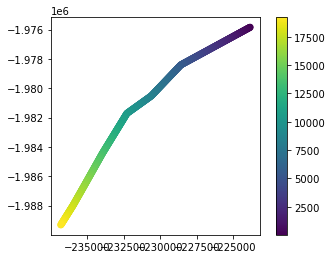

In [23]:
#OPEN DEM POLYGONS
polygons = gpd.read_file('DEM_sample_polygons/DEM_polygons.shp')
polygon = polygons[polygons['GlacierID']==1]

#OPEN CENTERLINES AND GET POINTS
centerlines_df = gpd.read_file('Centerlines/termpicks_centerlines/termpicks_centerlines.shp')
centerline_points = termpicks_centerline(centerlines_df,1).line2points(n_vert = 30)
centerline_points.plot(column = 'cumsum', legend=True)

#get cetroids of the termini
centroids = termini_gdf.centroid.to_list()

In [567]:
#FINDING NEW LOCATION OF TERMINI BASED ON STRESS COUPLING DISTANCE
indexs_closest = []
for i in centroids:
    closest = near(i,centerline_points)
    indexs_closest.append(centerline_points.loc[centerline_points['geometry'] == closest].index[0])
new_spot_index = [i-59 for i in indexs_closest]

x=[]
y=[]
for new,old in zip(new_spot_index,indexs_closest):
    
    new_y = centerline_points.iloc[new]['geometry'].y
    new_x = centerline_points.iloc[new]['geometry'].x
    
    old_y = centerline_points.iloc[old]['geometry'].y
    old_x = centerline_points.iloc[old]['geometry'].x
    
    trans_y = new_y-old_y
    trans_x = new_x-old_x
    
    x.append(trans_x)
    y.append(trans_y)
    
tmp = []
for index, poi in termini_gdf.iterrows():
    new_point = translate(termini_gdf.loc[index, 'geometry'], xoff=x[index], yoff=y[index])
    tmp.append({'geometry':new_point})

scd = gpd.GeoDataFrame(tmp,crs="EPSG:3413")
scd['Date'] = termini_gdf['Date']

scd.to_file('Terminus/New_traces/SCD_Termini/scd_termini_by_id/scd_termini_1.shp')

add section on interpoloation polygon


In [6]:
scd_e = gpd.read_file('Terminus/New_traces/SCD_Termini/scd_termini_by_id/scd_termini_1_extended.shp')
scd_e = scd_e.sort_values(by=['Date'],ignore_index=True)

termini_gdf = gpd.read_file('Terminus/New_traces/DEM_Traces_by_id/DEM_Traces_polar_1_extended.shp')
termini_gdf = termini_gdf.sort_values(by=['Date'],ignore_index=True)

loop = termini_gdf.index.to_list()
new_polygons = []
for i in loop:

    line1 = termini_gdf.iloc[i]['geometry']
    line2 = scd_e.iloc[i]['geometry']

    line1_pol = line1.buffer(1e-3)
    line2_pol = line2.buffer(1e-3)

    new_polygon = polygon.difference(line1_pol).difference(line2_pol)

    new_polygon = gpd.GeoDataFrame(new_polygon, crs="EPSG:3413", geometry = 0)
    exploded = new_polygon.explode(index_parts=True)
    if len(exploded) == 3:
        exploded['area'] = exploded.area
        exploded = exploded.loc[exploded['area']!=exploded['area'].max()]
        exploded = exploded.loc[exploded['area']!=exploded['area'].max()]
        new_polygons.append(exploded.iloc[0][0])
    else:
        exploded.plot()
termini_gdf['geometry'] = new_polygons

termini_gdf.to_file('DEM_sample_polygons/SC_crop/1.shp')

In [617]:
dems = termini_gdf['DEM'].to_list()
indx = termini_gdf.index.to_list()
for dem, i in zip(dems,indx):
    dem_path = os.path.join('Approved_DEMS/1/', dem)

    dem_im = rxr.open_rasterio(dem_path,
                                     masked=True).squeeze()

    crop_extent = termini_gdf[termini_gdf.index == i]
    clipped = dem_im.rio.clip(crop_extent.geometry.apply(mapping))
    path_to_tif_file = os.path.join("clipped_DEMS/1",
                                    crop_extent['DEM'].to_list()[0])

    # Write the data to a new geotiff file
    clipped.rio.to_raster(path_to_tif_file)


In [7]:
bed = rxr.open_rasterio('BedMachine/bed+geoid.tif', masked=True).squeeze()

indx = termini_gdf.index.to_list()
for i in indx:
    crop_extent = termini_gdf[termini_gdf.index == i]
    clipped = bed.rio.clip(crop_extent.geometry.apply(mapping))
    path_to_tif_file = os.path.join("BedMachine/Clipped_bed/1/",
                                    'bed_'+crop_extent['DEM'].to_list()[0])

    # Write the data to a new geotiff file
    clipped.rio.to_raster(path_to_tif_file)


In [2]:
termini_gdf = gpd.read_file('Terminus/New_traces/DEM_Traces_by_id/DEM_Traces_polar_1_extended.shp')
termini_gdf = termini_gdf.sort_values(by=['Date'],ignore_index=True)

In [ ]:
file_loop = termini_gdf['DEM'].to_list()
means=[]
medians=[]
counts=[]
stds=[]
for file in file_loop:
    bed_path = 'BedMachine/Clipped_bed/1/bed_'+file
    dem_path = 'Clipped_DEMs/1/'+file
    
    
    reproj_match(dem_path,bed_path,'Clipped_DEMs/150m/1/150_'+file)
    
    b = rxr.open_rasterio('BedMachine/Clipped_bed/1/bed_'+file, masked=True).squeeze()
    d =  rxr.open_rasterio('Clipped_DEMs/150m/1/150_'+file, masked=True).squeeze()
    
    
    ice_den = (b * 1.14)
    thickness = d - b
    hab = thickness+ice_den
    
    means.append(hab.mean().to_numpy().tolist())
    medians.append(hab.median().to_numpy().tolist())
    counts.append(hab.count().to_numpy().tolist())
    stds.append(hab.std().to_numpy().tolist())

    
    hab.rio.to_raster('HAB/1/hab_'+file)

In [20]:
termini_gdf['mean'] = means
termini_gdf['median'] = medians
termini_gdf['std'] = stds
termini_gdf['counts'] = counts

termini_gdf.to_file('HAB_Sampled/1.shp')

In [4]:
from rasterio.warp import reproject, Resampling, calculate_default_transform
import rasterio
def reproj_match(infile, match, outfile):
    """Reproject a file to match the shape and projection of existing raster. 
    
    Parameters
    ----------
    infile : (string) path to input file to reproject
    match : (string) path to raster with desired shape and projection 
    outfile : (string) path to output file tif
    """
    # open input
    with rasterio.open(infile) as src:
        src_transform = src.transform
        
        # open input to match
        with rasterio.open(match) as match:
            dst_crs = match.crs
            
            # calculate the output transform matrix
            dst_transform, dst_width, dst_height = calculate_default_transform(
                src.crs,     # input CRS
                dst_crs,     # output CRS
                match.width,   # input width
                match.height,  # input height 
                *match.bounds,  # unpacks input outer boundaries (left, bottom, right, top)
            )

        # set properties for output
        dst_kwargs = src.meta.copy()
        dst_kwargs.update({"crs": dst_crs,
                           "transform": dst_transform,
                           "width": dst_width,
                           "height": dst_height,
                           "nodata": 0})
        print("Coregistered to shape:", dst_height,dst_width,'\n Affine',dst_transform)
        # open output
        with rasterio.open(outfile, "w", **dst_kwargs) as dst:
            # iterate through bands and write using reproject function
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=dst_transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

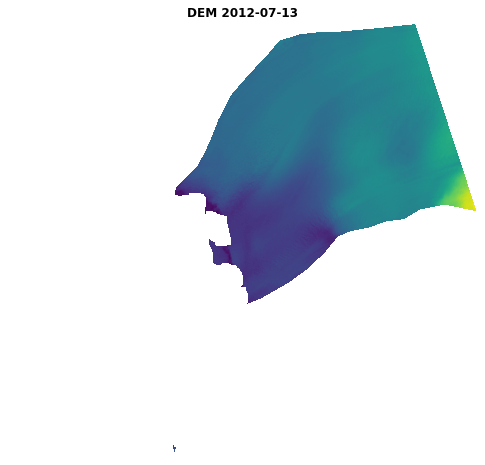

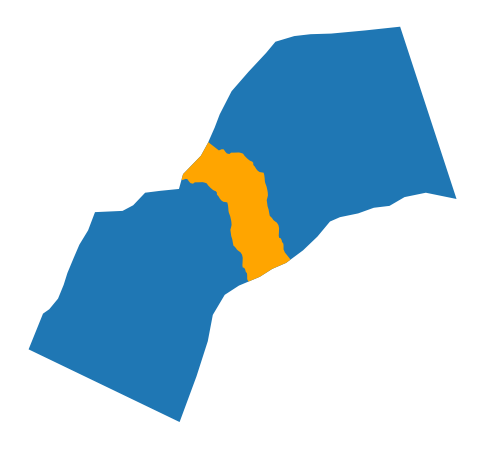

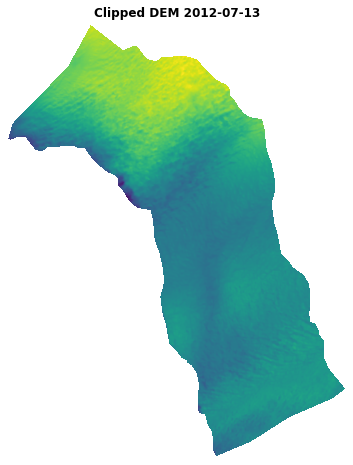

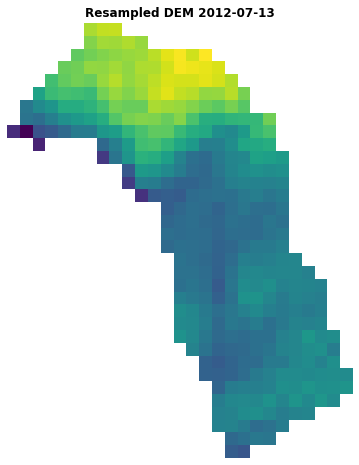

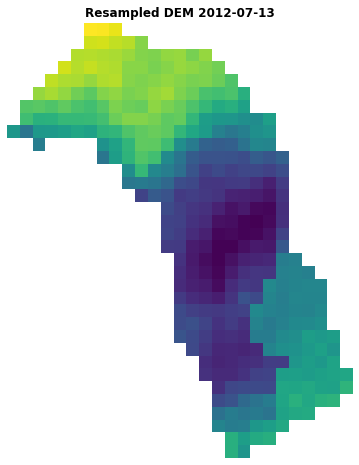

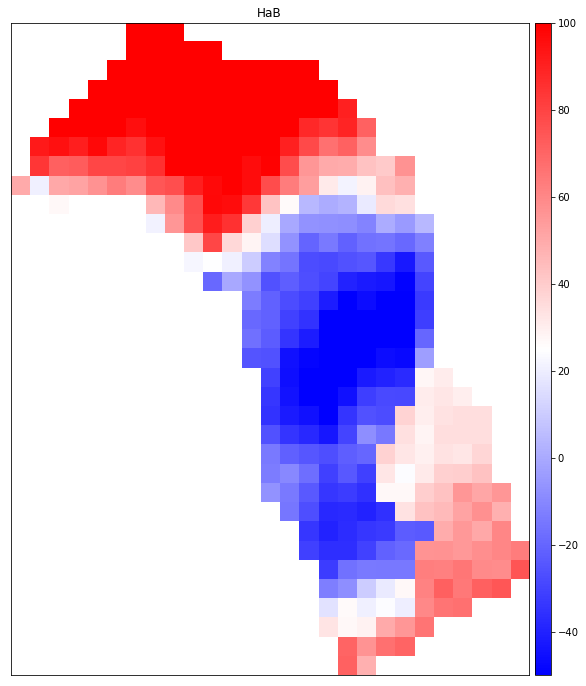

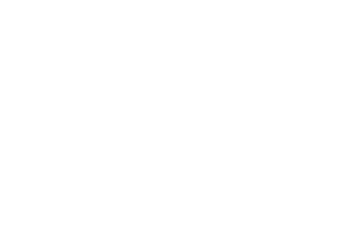

In [105]:
new_poly = new_poly[new_poly['Date']=='2012-07-13']
file = new_poly.DEM.to_list()[0]


d =  rxr.open_rasterio('Approved_DEMs/1/'+file, masked=True).squeeze()
fig, ax = plt.subplots(figsize = (10,8))
from rasterio.plot import show
show(d, 
     title="DEM 2012-07-13", 
     ax=ax)
ax.set_axis_off()

fig, ax = plt.subplots(figsize = (10,8))
polygon.plot(ax=ax)
new_poly.plot(ax=ax,color = 'Orange', label = 'Stress coupling length')
ax.set_axis_off()

d =  rxr.open_rasterio('Clipped_DEMs/1/'+file, masked=True).squeeze()
fig, ax = plt.subplots(figsize = (10,8))
from rasterio.plot import show
show(d, 
     title="Clipped DEM 2012-07-13", 
     ax=ax)
ax.set_axis_off()



d =  rxr.open_rasterio('Clipped_DEMs/150m/1/150_'+file, masked=True).squeeze()
fig, ax = plt.subplots(figsize = (10,8))
from rasterio.plot import show
show(d, 
     title="Resampled DEM 2012-07-13", 
     ax=ax)
ax.set_axis_off()



d =  rxr.open_rasterio('HAB/1/hab_'+file, masked=True).squeeze()
fig, ax = plt.subplots(figsize = (10,8))
from rasterio.plot import show
show(d, 
     title="Resampled DEM 2012-07-13", 
     ax=ax)
ax.set_axis_off()

ep.plot_bands(d,
              cmap='bwr',
              vmin=-50,vmax=100,
              title="HaB",
              scale=False)
plt.axis('off')
plt.show()

In [90]:
orig_cmap = matplotlib.cm.bwr
shifted_cmap = shiftedColorMap(orig_cmap, midpoint=0,  name='shifted')

C:\Users\sofyg\AppData\Local\Temp/ipykernel_29288/337466594.py:53: UserWarning: Trying to register the cmap 'shifted' which already exists.
  plt.register_cmap(cmap=newcmap)
